In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import numpy as np
import verde as vd

In [2]:
# We'll test this on the Baja California shipborne bathymetry data
data = vd.datasets.fetch_baja_bathymetry()
data.head()

,longitude,latitude,bathymetry_m
0,245.00891,27.49555,-636.0
1,245.01201,27.49286,-655.0
2,245.01512,27.49016,-710.0
3,245.01822,27.48746,-695.0
4,245.02443,27.48206,-747.0


In [21]:
# Before gridding, we need to decimate the data to avoid aliasing because of
# the oversampling along the ship tracks. We'll use a blocked median with 5
# arc-minute blocks.
spacing = 5/60
lon, lat, bathymetry = vd.block_reduce(data.longitude, data.latitude,
                                       data.bathymetry_m, reduction=np.median,
                                       spacing=spacing)

In [22]:
# Project the data using pyproj so that we can use it as input for the gridder.
# We'll set the latitude of true scale to the mean latitude of the data.
projection = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())
easting, northing = projection(lon, lat)

In [25]:
%%time
# Now we can set up a gridder for the decimated data
grd = vd.BiharmonicSpline(fudge=1e-5).fit(easting, northing, bathymetry)
print("Gridder used:", grd)

LinAlgError: Matrix is singular.

In [6]:
# Get the grid region in geographic coordinates
region = vd.get_region(data.longitude, data.latitude)
print("Data region:", region)

Data region: (245.0, 254.705, 20.0, 29.99131)


In [7]:
grd.predict(np.ones(10), np.zeros(10))

array([930607.82719839, 930607.82719839, 930607.82719839, 930607.82719839,
       930607.82719839, 930607.82719839, 930607.82719839, 930607.82719839,
       930607.82711828, 930607.82711828])

In [8]:
# The 'grid' method can still make a geographic grid if we pass in a projection
# function that converts lon, lat into the easting, northing coordinates that
# we used in 'fit'. This can be any function that takes lon, lat and returns x,
# y. In our case, it'll be the 'projection' variable that we created above.
# We'll also set the names of the grid dimensions and the name the data
# variable in our grid (the default would be 'scalars', which isn't very
# informative).
grid = grd.grid(region=region, spacing=spacing, projection=projection,
                dims=['latitude', 'longitude'], data_names=['bathymetry_m'])
print("Generated geographic grid:")
print(grid)

Generated geographic grid:
<xarray.Dataset>
Dimensions:       (latitude: 61, longitude: 59)
Coordinates:
  * longitude     (longitude) float64 245.0 245.2 245.3 245.5 245.7 245.8 ...
  * latitude      (latitude) float64 20.0 20.17 20.33 20.5 20.67 20.83 21.0 ...
Data variables:
    bathymetry_m  (latitude, longitude) float64 -3.619e+03 -3.719e+03 ...
Attributes:
    metadata:  Generated by BiharmonicSpline(damping=None, fudge=10, spacing=...


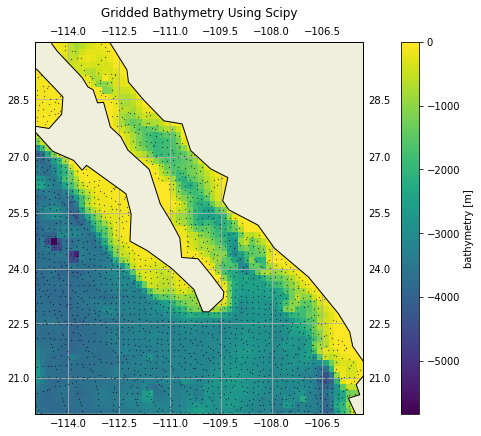

In [9]:


# Cartopy requires setting the coordinate reference system (CRS) of the
# original data through the transform argument. Their docs say to use
# PlateCarree to represent geographic data.
crs = ccrs.PlateCarree()

plt.figure(figsize=(7, 6))
# Make a Mercator map of our gridded bathymetry
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Gridded Bathymetry Using Scipy", pad=25)
# Plot the gridded bathymetry
pc = ax.pcolormesh(grid.longitude, grid.latitude, grid.bathymetry_m,
                   transform=crs, vmax=0)
cb = plt.colorbar(pc, pad=0.08)
cb.set_label('bathymetry [m]')
# Plot the locations of the decimated data
ax.plot(lon, lat, '.k', markersize=0.5, transform=crs)
# Plot the land as a solid color
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=2)
ax.set_extent(region, crs=crs)
ax.gridlines(draw_labels=True)
plt.tight_layout()
plt.show()